<p xmlns:cc="http://creativecommons.org/ns#" xmlns:dct="http://purl.org/dc/terms/"><span property="dct:title">MyFirstTransportMonteCarloCode</span> by <span property="cc:attributionName">Manuel Cotelo Ferreiro (Universidad Politécnica de Madrid)</span> is licensed under <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/?ref=chooser-v1" target="_blank" rel="license noopener noreferrer" style="display:inline-block;">CC BY-NC-SA 4.0<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/nc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1"></a></p>

# MyFirstTransportMonteCarloCode

In [78]:
import os
import sys
from argparse import Namespace as NS

import numpy as np

import scipy

import pyvista as pv

import matplotlib.pyplot as plt

## Introducción

A continuación vamos a tratar de implementar un código de transporte de Monte Carlo para partículas neutras que no interactuan entre sí (neutrones y gammas). Vamos a realizarlo de manera muy naïve, pero nos ayudará a identificar las partes de la simulación.

### Vocabulario

<dl>
    <dt>Iniciador: </dt><dd>Proceso iniciador del modelo microscópico de transporte</dd>
    <dt>Evento: </dt><dd>Conjunto de todos los procesos que suceden a partir de un iniciador.</dd>
    <dt>Historia: </dt><dd>Conjunto de estados del modelo microscopico de transporte desde su creación (posiblemente el iniciador u otra historia) hasta que se da lugar un procedo de extinción.</dd>
</dl>

### Elementos de una simulación de Monte Carlo de Transporte de partículas

* Dominio
* Geometría
* Particle Gun
* Trazado de rayos
* Tallies: accumulación

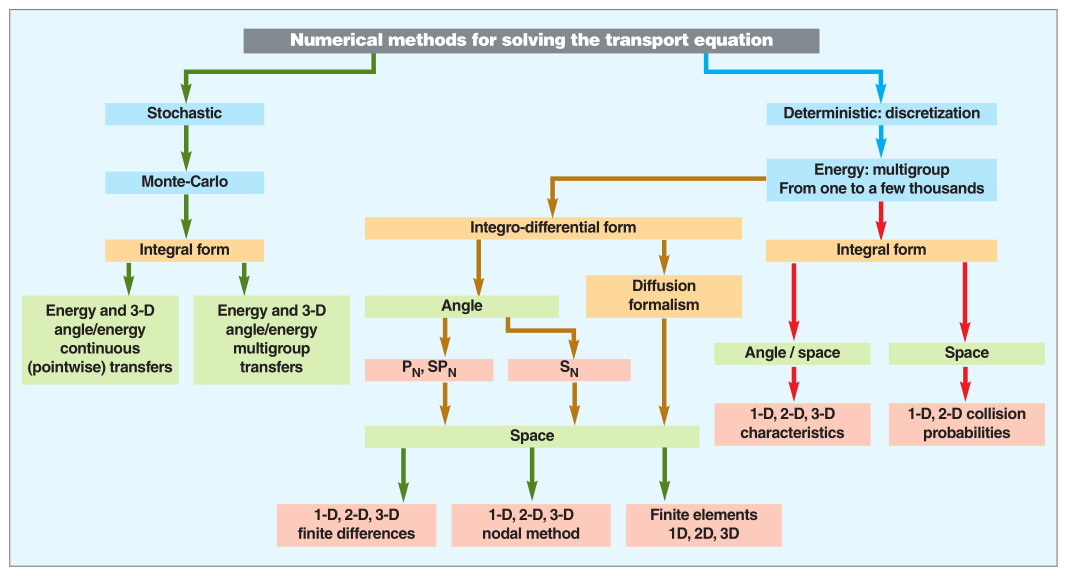

### Pasos para la resolución por Monte Carlo

1. Crear un proceso estadístico que llamaremos "juego" que empieza con un suceso iniciador, lo que denominamos fuente, reproducimos la historia de la particula de nace de ese suceso iniciador, representada por un conjunto de trayectorias y de colisiones que determinan casa trayectoria (dispersión, absorción, ...). Esto da lugar a una cadena de localizaciones de sucesos (emisión de partículas, colisiones, extinción).

2. Se define una variable aleatoria $X(Z)$ que esté acplada a la magnitud de interés $R(Z)$. A la magnitud $X(Z)$ se le denomina estimador de $R(Z)$. Cuando un neutron entra en el áera $Z$ duante su historia, se accumula este suceso añadiendo un cierto peso $\omega$ (score, tally, payoff, ...) al estimador $X(Z)$.

3. Las reglas del juego se determinan mediante la definición de las densidades de probabilidad con la que se seleccionan los eventos que van a ocurrir. En el caso de partículas se trata dde escoger su camino, la naturaleza de sus interacciones, y en el caso de dispersión, su nueva energy y trayectoria. Esto se consigue de una manera aleatoria y de acuerdo con las características físicas de la fuente de particulas y con las leyes de la física que rigen en la interacción de esa partícula con la materia.

4. Sa realiza un gran número de veces $M$ el juego de manera independiente, simulando la historia de las particulas.

5. Evaluar la magnitud de interés $R$ aplicando la ley de grandes números (N debe ser suficientemente grande).

## Dominio

In [79]:
# make the domain a box in 3D, [-1,1]^3

domain = NS(
  
  span = np.array( [
    [ -1,  1., ],
    [ -1,  1., ],
    [ -1,  1., ],
  ]),

)

## Geometría

Debemos definir la geometría de nuestro sistema, es decir, los volúmenes ocupados y los materiales de cada volumen. Para ello vamos a delegar las operaciones en un modulo de gestión de geometrías basado en **VTK** (Volume ToolKit) llamado **pyvista**.

/home/mcotelo/.local/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


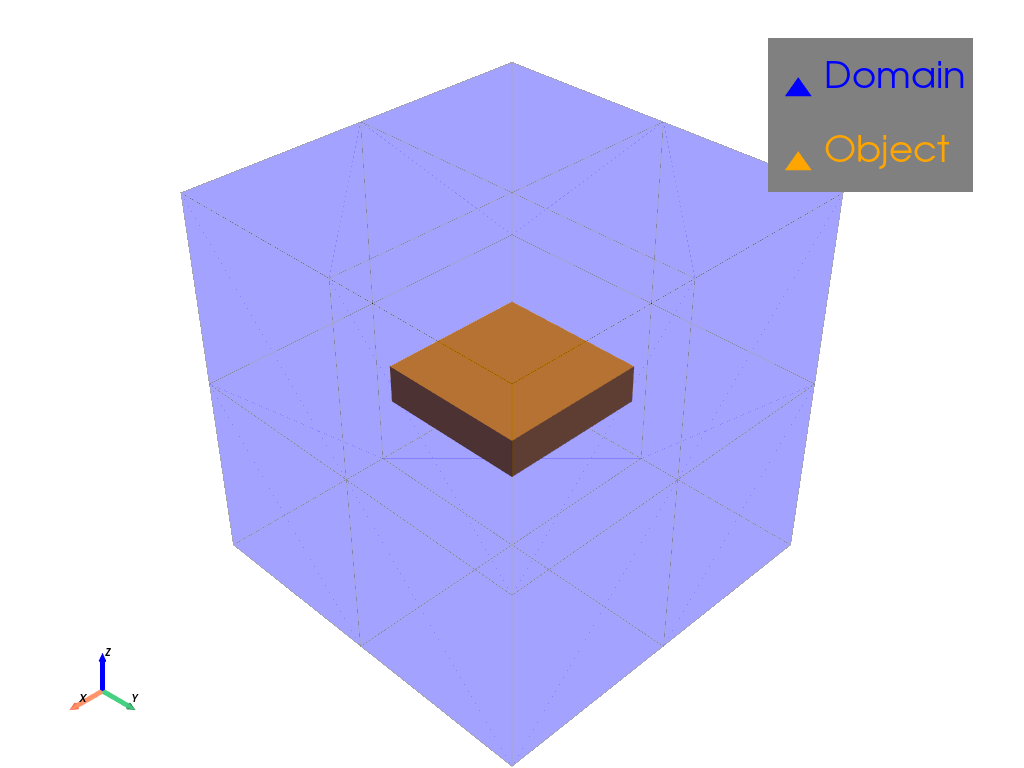

In [80]:
# define a volume for the domain
domain.vol = pv.Box( domain.span.flatten(), level=1, )  

# define a list of objects inside the domain
domain.objs = []

# add a foil to the domain
pos_center = np.zeros(3)
thickness = 0.20
lx, ly = .80, .80

foil = pv.Box( [
    pos_center[0] - .5*lx,
    pos_center[0] + .5*lx,
    pos_center[1] - .5*ly,
    pos_center[1] + .5*ly,
    pos_center[2]-thickness/2.,
    pos_center[2]+thickness/2.,
] )

domain.objs.append(foil)

# print domain and objs
p = pv.Plotter(off_screen=True)
p.add_mesh( domain.vol, show_edges=True, opacity=0.2, color="blue", lighting=False, label="Domain")
for obj in domain.objs:
  p.add_mesh( obj, color="orange", line_width=5, label="Object")
p.add_legend()
axes = p.add_axes( line_width=5, )
p.show()

### Materiales

### Trazado de rayos

El proceso básico de cálculo será el cálculo de la trayectoria de una partícula en el medio. Dado que ytratamos partículas neutras (neutrones y gamma), estas paerticulas seguirán una trayectoria recta entre colisión y colisión.

In [81]:
# define a Ray
class Ray():
    def __init__( self, pos, dir, weight = 1., ):
        self.pos = pos
        self.dir = dir
        self.weight = weight
        return
        
    def advance( self, length, ):
        return self.pos + length * self.dir
    def __repr__( self, ):
        return f'{self.pos} {self.dir}'

/home/mcotelo/.local/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


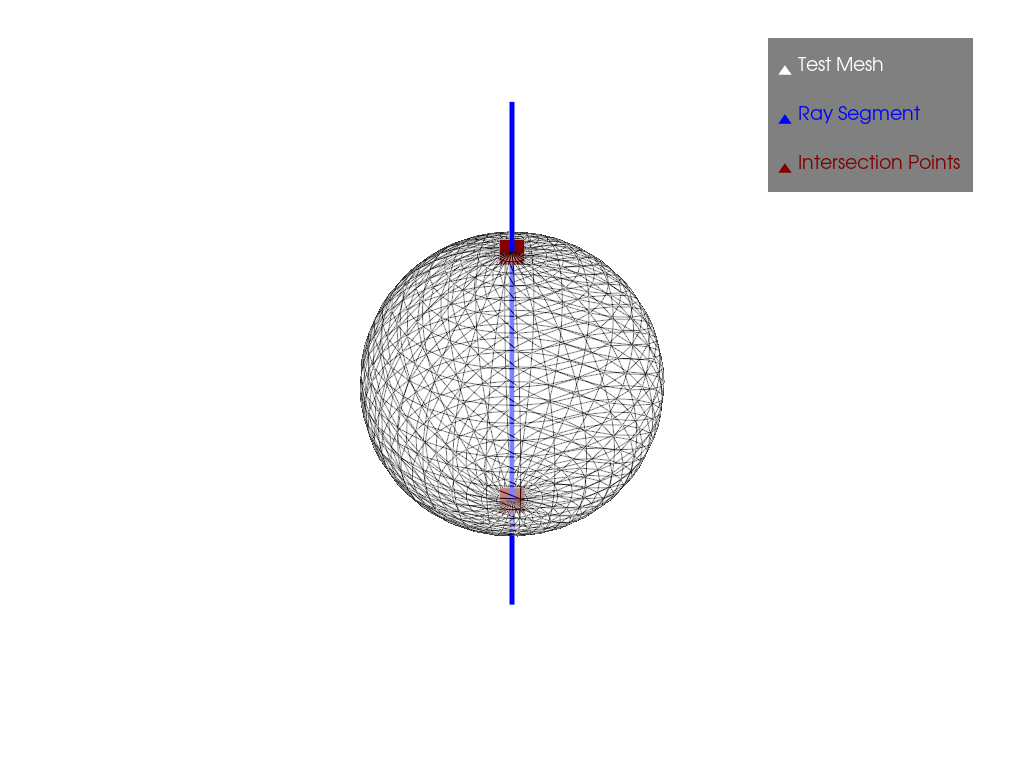

In [82]:
# create a ray
ray = Ray( np.array( [ 0., 0., -2.,], ), np.array( [ 0., 0., 1., ], ), )
          
# create a sphere
sphere = pv.Sphere( radius=1., )

# intersection
points, rays, cells = sphere.multi_ray_trace( [ray.pos], [ray.dir], first_point=False, retry=True, )

# create line for the ray
line = pv.Line( ray.pos, ray.advance(4.))
intersection = pv.PolyData(points)

# Render the result
p = pv.Plotter(off_screen=True)
p.add_mesh( sphere, show_edges=True, opacity=0.5, color="w", lighting=False, label="Test Mesh")
p.add_mesh( line, color="blue", line_width=5, label="Ray Segment")
p.add_mesh( intersection, color="maroon", point_size=25, label="Intersection Points")
p.add_legend()
p.show()

## Particle gun

Se trata de determinar el iniciador del evento: una partícula, una desintegración, etc.

In [83]:
class Particle():

    def __init__( self, id, ray, energy, ):
        assert energy > 0., 'bad energy'
        self.id = id
        self.ray = ray
        self.energy = energy
        return
        
    def __repr__( self, ):
        return f'{self.id:12s} {self.ray} {self.energy:15.7e}'

class ParticleGun():

    def __init__( self, dist_pos, dist_dir, dist_ene, ):
        self.dp = dist_pos
        self.dd = dist_dir
        self.de = dist_ene
        return

    def __call__( self, ):
        return Particle(
            id = 'neutron',
            ray = Ray(
                pos = self.dp(),
                dir = self.dd(),
                weight = 1.,
            ),
            energy = self.de(), # in MeV
        )

In [84]:
# example 

# fixed position
func_pos = lambda : np.array( [ 0., 0., domain.span[2][0], ], )
# fixed direction
func_dir = lambda : np.array( [ 0., 0., 1., ], )

# gaussian distribution of energy with mu = 2 MeV and sigma = 0.1 MeV
func_gauss = scipy.stats.norm( loc=2., scale=0.1, )
def func_ene():
    ene = func_gauss.rvs(1)[0]
    while ene <= 0.:
        ene = func_gauss.rvs(1)[0]
    return ene

gun = ParticleGun( func_pos, func_dir, func_ene, )

num_samples = 20
for i in range(num_samples):
    print( gun(), )

neutron      [ 0.  0. -1.] [0. 0. 1.]   2.0300648e+00
neutron      [ 0.  0. -1.] [0. 0. 1.]   2.0103638e+00
neutron      [ 0.  0. -1.] [0. 0. 1.]   2.0099685e+00
neutron      [ 0.  0. -1.] [0. 0. 1.]   2.0240549e+00
neutron      [ 0.  0. -1.] [0. 0. 1.]   2.0089065e+00
neutron      [ 0.  0. -1.] [0. 0. 1.]   1.8905809e+00
neutron      [ 0.  0. -1.] [0. 0. 1.]   2.0596155e+00
neutron      [ 0.  0. -1.] [0. 0. 1.]   1.9498146e+00
neutron      [ 0.  0. -1.] [0. 0. 1.]   2.0457123e+00
neutron      [ 0.  0. -1.] [0. 0. 1.]   1.9167709e+00
neutron      [ 0.  0. -1.] [0. 0. 1.]   2.1521643e+00
neutron      [ 0.  0. -1.] [0. 0. 1.]   1.9881607e+00
neutron      [ 0.  0. -1.] [0. 0. 1.]   1.9485668e+00
neutron      [ 0.  0. -1.] [0. 0. 1.]   1.8613568e+00
neutron      [ 0.  0. -1.] [0. 0. 1.]   1.9341310e+00
neutron      [ 0.  0. -1.] [0. 0. 1.]   2.1280858e+00
neutron      [ 0.  0. -1.] [0. 0. 1.]   2.1444924e+00
neutron      [ 0.  0. -1.] [0. 0. 1.]   2.0411438e+00
neutron      [ 0.  0. -1.] [

### Modelo microscópico del proceso

Trazado de la trayectoria del neutron a través del sistema hasta que se absorba o se escape.

In [86]:
def next_intersection( list_objs, particle, tol=1.e-9, ):

    index = -1
    l = np.inf
    
    for i, obj in enumerate(list_objs):
        # intersection
        points, rays, cells = obj.multi_ray_trace( 
            [ particle.ray.pos, ], 
            [ particle.ray.dir, ], 
            first_point=False, 
            retry=True, 
        )
        # interaction lengths
        delta = points - particle.ray.pos
        delta = np.linalg.norm( delta, axis=-1, )
        lmin = np.amin( delta)
        # check length
        if lmin < l:
            l = lmin
            index = i
            
    return index, l
      
    
def trace( domain, particle, ):

    # check wherther the particle is in the domain and move the 
    # particle to the boundary in negative case

    # get collision of the rays with the objects
    pass

### Procesos

* Procesos de dispersión (scattering)
* Procesos de extinción ( absorción)
* Procesos de creación (fisión, desintegraciones)

## Tallies: acumulación de resultados